## Explanatory Data analysis

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

from sklearn.metrics import r2_score, mean_squared_error


import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import numpy as np
import pandas as pd

from ipywidgets import Dropdown, VBox, Output
from IPython.display import display



In [2]:
# Paths 2020 and 2024
csv_path2020_euroSciVoc = "../data/cordis-h2020projects-csv/euroSciVoc.csv"
csv_path2020_organization = "../data/cordis-h2020projects-csv/organization.csv"
csv_path2020_publication_citation = "../data/cordis-h2020projects-csv/updated_publications_with_citations_2020.csv"

csv_path2024_euroSciVoc = "../data/cordis-HORIZONprojects-csv/euroSciVoc.csv"
csv_path2024_organization = "../data/cordis-HORIZONprojects-csv/organization.csv"
csv_path2024_publication_citation = "../data/cordis-HORIZONprojects-csv/updated_publications_with_citations_2024.csv"


In [3]:
# Dataframes inlezen
df2020_euroSciVoc = pd.read_csv(csv_path2020_euroSciVoc, delimiter=";", on_bad_lines="skip", low_memory=False)
df2020_organization = pd.read_csv(csv_path2020_organization, delimiter=";", on_bad_lines="skip", low_memory=False)
df2020_publication_citation = pd.read_csv(csv_path2020_publication_citation, delimiter=",", on_bad_lines="skip", low_memory=False)

# Verplichte kolommen per dataframe
cleaning_specs = {
    "df2020_organization": ["projectID", "organisationID", "role", "country", "ecContribution"],
    "df2020_euroSciVoc": ["projectID"],
    "df2020_publication_citation": ["doi", "title", "publishedYear", "citation_count"]
}

# Opschonen: duplicates en rows met ontbrekende kernwaarden verwijderen
for name, required_cols in cleaning_specs.items():
    df = globals()[name]
    df.drop_duplicates(inplace=True)
    df.dropna(subset=required_cols, inplace=True)


In [4]:
# Dataframes inlezen
df2024_euroSciVoc = pd.read_csv(csv_path2024_euroSciVoc, delimiter=";", on_bad_lines="skip", low_memory=False)
df2024_organization = pd.read_csv(csv_path2024_organization, delimiter=";", on_bad_lines="skip", low_memory=False)
df2024_publication_citation = pd.read_csv(csv_path2024_publication_citation, delimiter=",", on_bad_lines="skip", low_memory=False)

# Verplichte kolommen per dataframe
cleaning_specs_2024 = {
    "df2024_organization": ["projectID", "organisationID", "role", "country", "ecContribution"],
    "df2024_euroSciVoc": ["projectID"],
    "df2024_publication_citation": ["doi", "title", "publishedYear", "citation_count"]
}

# Opschonen zonder prints
for name, required_cols in cleaning_specs_2024.items():
    df = globals()[name]
    df.drop_duplicates(inplace=True)
    df.dropna(subset=required_cols, inplace=True)



In [5]:
# Add a 'source' column to each dataframe before concatenation

# ORGANIZATION — funding and coordinator roles per country
df2020_organization['source'] = '2020'
df2024_organization['source'] = '2024'
df_organization = pd.concat([df2020_organization, df2024_organization], ignore_index=True)

# EUROSCIVOC — linking projects to categories
df2020_euroSciVoc['source'] = '2020'
df2024_euroSciVoc['source'] = '2024'
df_euroSciVoc = pd.concat([df2020_euroSciVoc, df2024_euroSciVoc], ignore_index=True)

# PUBLICATION CITATION — citation data for publications
df2020_publication_citation['source'] = '2020'
df2024_publication_citation['source'] = '2024'
df_publication_citation = pd.concat([df2020_publication_citation.drop_duplicates(), df2024_publication_citation.drop_duplicates()], ignore_index=True)

# (Optional) Print shapes to confirm
print("df_organization shape:", df_organization.shape)
print("df_euroSciVoc shape:", df_euroSciVoc.shape)
print("df_publication_citation shape:", df_publication_citation.shape)

df_organization shape: (254699, 26)
df_euroSciVoc shape: (152982, 6)
df_publication_citation shape: (377887, 18)


In [6]:
# Extract category from the concatenated dataframe
df_euroSciVoc['category'] = df_euroSciVoc['euroSciVocPath'].str.split('/').str[1]

df_publication_citation['projectID'] = pd.to_numeric(df_publication_citation['projectID'], errors='coerce')
df_euroSciVoc['projectID'] = df_euroSciVoc['projectID']
# Merge publications with project categories
df_pubs_cat = pd.merge(df_publication_citation, df_euroSciVoc[['projectID', 'category']], on='projectID', how='left')

# Use publishedYear as 'Year'
df_pubs_cat['Year'] = pd.to_numeric(df_pubs_cat['publishedYear'], errors='coerce').astype('Int64')

# Prepare data: count publications and sum citations per category per year
category_year_stats = (
    df_pubs_cat
    .groupby(['category', 'Year'])
    .agg(
        publication_count=('id', 'count'),
        total_citations=('citation_count', 'sum')
    )
    .reset_index()
)

In [7]:
# Step 1: Replace -1 with np.nan for imputation
df_publication_citation['citation_count'] = df_publication_citation['citation_count'].replace(-1, np.nan)

# Count how many will be purged (no valid citation_count in project)
valid_counts = df_publication_citation.groupby('projectID')['citation_count'].transform(lambda x: x.notna().sum())
purge_mask = (df_publication_citation['citation_count'].isna()) & (valid_counts == 0)
n_purged = purge_mask.sum()

# Remove these rows
df_publication_citation = df_publication_citation[~purge_mask].copy()

# Count how many will be substituted (missing but project has valid values)
substitute_mask = df_publication_citation['citation_count'].isna()
n_substituted = substitute_mask.sum()

def impute_group_mean(group):
    imputer = SimpleImputer(strategy='mean')
    group['citation_count'] = imputer.fit_transform(group[['citation_count']])
    return group

df_publication_citation = df_publication_citation.groupby('projectID', group_keys=False).apply(impute_group_mean)

print(f"Number of citation counts substituted with project mean: {n_substituted}")
print(f"Number of publications purged (no valid citation_count in project): {n_purged}")
# Prepare data: sum citations per category per year
citations_per_topic_year = (
    df_pubs_cat
    .groupby(['Year', 'category'])
    .agg(total_citations=('citation_count', 'sum'))
    .reset_index()
)

/var/folders/4v/zr3kb4917zn6dghk4y1t743w0000gn/T/ipykernel_93221/3321905544.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_publication_citation = df_publication_citation.groupby('projectID', group_keys=False).apply(impute_group_mean)


Number of citation counts substituted with project mean: 19842
Number of publications purged (no valid citation_count in project): 800


In [9]:
# Optional: add a 'Year' column for convenience
df_pubs_cat['Year'] = pd.to_numeric(df_pubs_cat['publishedYear'], errors='coerce').astype('Int64')

# Filter valid citation counts
df_pubs_cat_valid = df_pubs_cat[(df_pubs_cat['citation_count'].notna()) & (df_pubs_cat['citation_count'] != -1)]

# Print how many are not valid
n_invalid = len(df_pubs_cat) - len(df_pubs_cat_valid)
print(f"Number of rows with invalid citation_count (NA or -1): {n_invalid}")


# 1. Aggregate total citations per project
project_citations = (
    df_pubs_cat_valid.groupby('projectID')
    .agg(total_citations=('citation_count', 'sum'))
    .reset_index()
)

# 2. Get funding, coordinator country, and research category for each project
# Funding: sum ecContribution per project
project_funding = (
    df_organization.groupby('projectID')['ecContribution'].sum().reset_index()
)

# Coordinator country: take the country where role == 'coordinator'
coordinator_country = (
    df_organization[df_organization['role'].str.lower() == 'coordinator']
    .groupby('projectID')['country'].first().reset_index()
)

# Research category: take the first category for each project
project_category = (
    df_euroSciVoc.groupby('projectID')['category'].first().reset_index()
)

# Years since publication (as of 20.05.2025)
dataset_update_date = datetime(2025, 5, 20)
project_year = (
    df_pubs_cat.groupby('projectID')['publishedYear']
    .min()
    .reset_index()
    .rename(columns={'publishedYear': 'first_publication_year'})
)
project_year['projectID'] = project_year['projectID'].astype(str)
project_year['first_publication_year'] = pd.to_numeric(project_year['first_publication_year'], errors='coerce')
project_year['years_since_publication'] = (
    dataset_update_date.year - project_year['first_publication_year']
).astype('Float64')

# Ensure projectID is string in all relevant DataFrames
project_citations['projectID'] = project_citations['projectID'].astype(str)
project_funding['projectID'] = project_funding['projectID'].astype(str)
coordinator_country['projectID'] = coordinator_country['projectID'].astype(str)
project_category['projectID'] = project_category['projectID'].astype(str)

# Merge all features
df_reg = project_citations.merge(project_funding, on='projectID', how='left') \
    .merge(coordinator_country, on='projectID', how='left') \
    .merge(project_category, on='projectID', how='left') \
    .merge(project_year[['projectID', 'years_since_publication']], on='projectID', how='left')

# Drop rows with missing values in any explanatory variable
df_reg = df_reg.dropna(subset=['ecContribution', 'country', 'category', 'total_citations', 'years_since_publication'])
df_reg = df_reg[df_reg['years_since_publication'] >= 0]


Number of rows with invalid citation_count (NA or -1): 63216


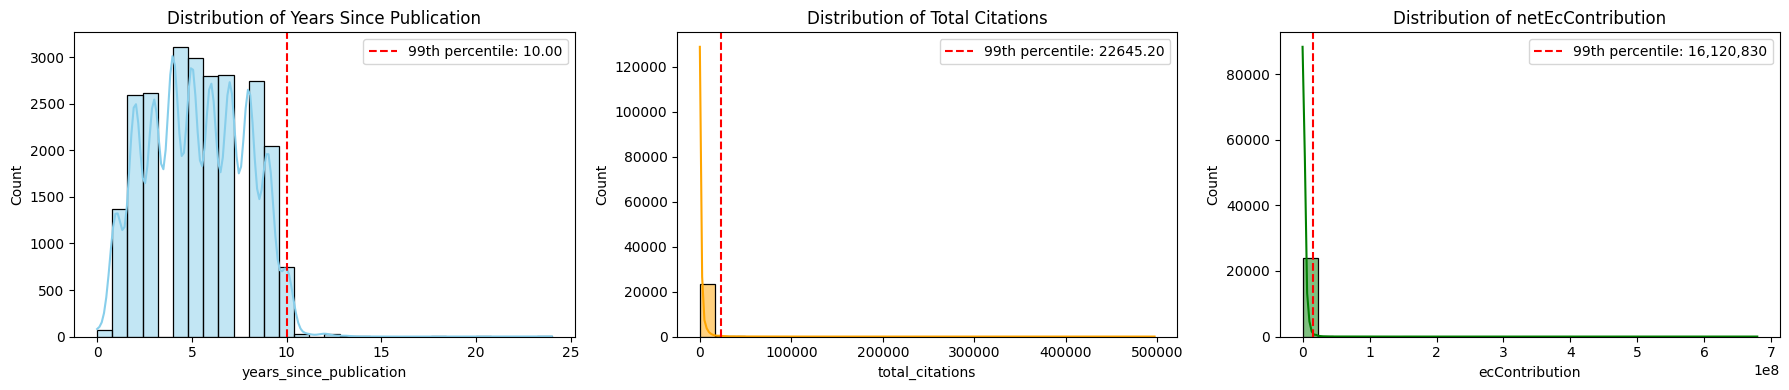

Correlation matrix:
                         years_since_publication  total_citations  \
years_since_publication                 1.000000         0.266083   
total_citations                         0.266083         1.000000   
ecContribution                          0.008852         0.179844   

                         ecContribution  
years_since_publication        0.008852  
total_citations                0.179844  
ecContribution                 1.000000  


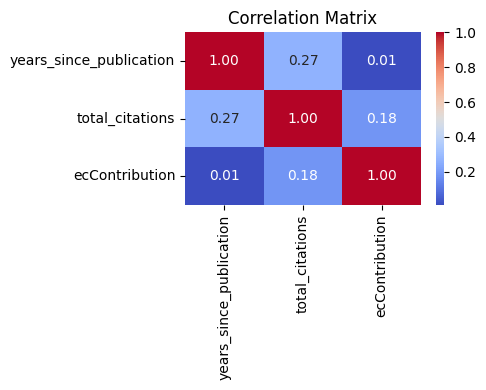

In [14]:
# Assume df is your regression dataset and has the relevant columns
df = df_reg.copy()

# 1. Distribution plots with 99th percentile
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# years_since_publication
sns.histplot(df['years_since_publication'], bins=30, ax=axes[0], kde=True, color='skyblue')
p99_ysp = np.percentile(df['years_since_publication'].dropna(), 99)
axes[0].axvline(p99_ysp, color='red', linestyle='--', label=f'99th percentile: {p99_ysp:.2f}')
axes[0].set_title('Distribution of Years Since Publication')
axes[0].set_xlabel('years_since_publication')
axes[0].legend()

# citation_count
sns.histplot(df['total_citations'], bins=30, ax=axes[1], kde=True, color='orange')
p99_cit = np.percentile(df['total_citations'].dropna(), 99)
axes[1].axvline(p99_cit, color='red', linestyle='--', label=f'99th percentile: {p99_cit:.2f}')
axes[1].set_title('Distribution of Total Citations')
axes[1].set_xlabel('total_citations')
axes[1].legend()

# netEcContribution
sns.histplot(df['ecContribution'], bins=30, ax=axes[2], kde=True, color='green')
p99_fund = np.percentile(df['ecContribution'].dropna(), 99)
axes[2].axvline(p99_fund, color='red', linestyle='--', label=f'99th percentile: {p99_fund:,.0f}')
axes[2].set_title('Distribution of netEcContribution')
axes[2].set_xlabel('ecContribution')
axes[2].legend()

plt.tight_layout()
plt.show()

# 2. Correlation matrix and heatmap
corr = df[['years_since_publication', 'total_citations', 'ecContribution']].corr()
print("Correlation matrix:")
print(corr)

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

Summary statistics:
       log_ecContribution  years_since_publication  log_total_citations
count        23907.000000                  23907.0         23907.000000
mean            13.999792                 5.276404             5.407311
std              1.389474                 2.496073             2.358125
min             11.139160                      0.0             0.000000
25%             12.268741                      3.0             3.891820
50%             14.391290                      5.0             5.620401
75%             15.004412                      7.0             7.143618
max             20.314678                     10.0            11.973485


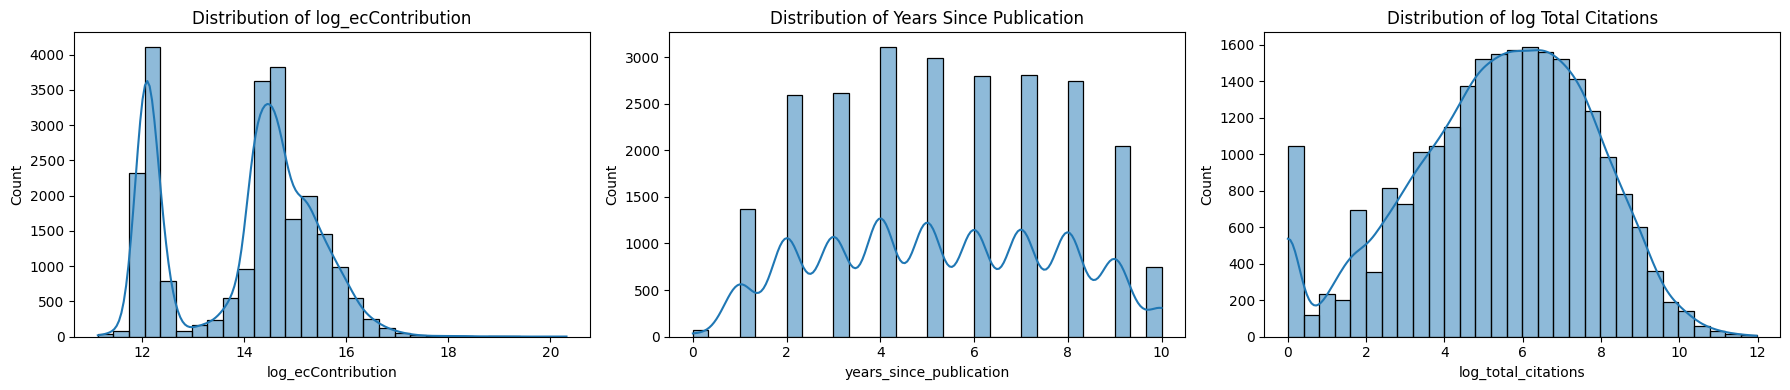

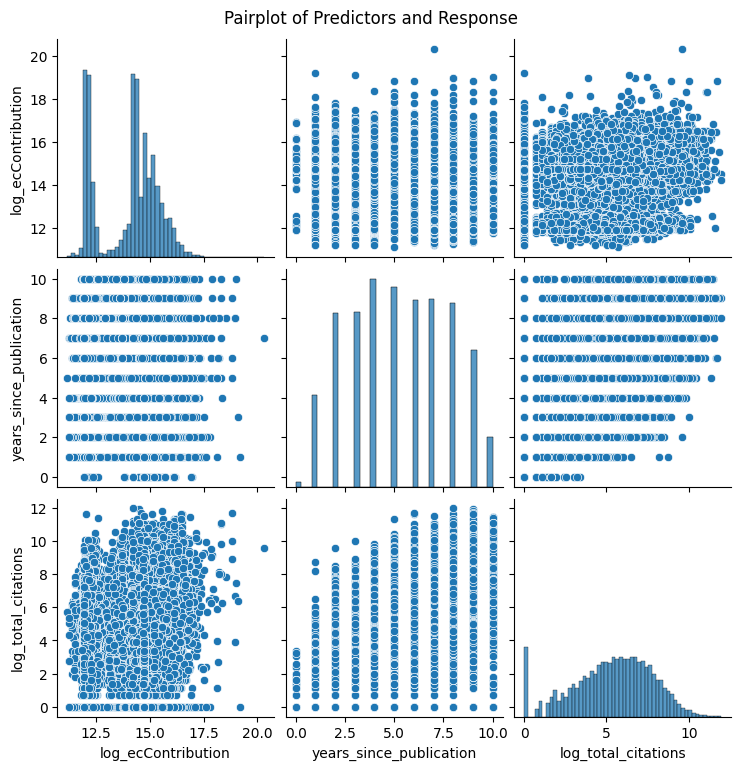

Correlation matrix:
                         log_ecContribution  years_since_publication  \
log_ecContribution                 1.000000                 0.011866   
years_since_publication            0.011866                 1.000000   
total_citations                    0.153920                 0.296989   

                         total_citations  
log_ecContribution              0.153920  
years_since_publication         0.296989  
total_citations                 1.000000  


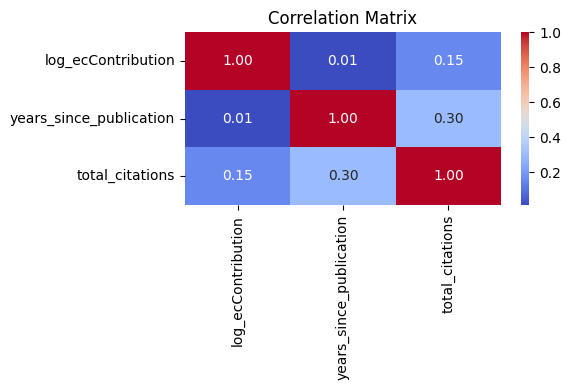

In [ ]:
# Use the filtered regression dataset
# Remove outliers
outliers = df[(df['years_since_publication'] > 10)]
df = df[~df['projectID'].isin(outliers['projectID'])]
df = df.reset_index(drop=True)

# Calculate 95th percentiles
# Add log-transformed columns (log1p handles zeros)
df['log_total_citations'] = np.log1p(df['total_citations'])
df['log_ecContribution'] = np.log1p(df['ecContribution'])



# 1. Summary statistics for numerical predictors and response
print("Summary statistics:")
print(df[['log_ecContribution', 'years_since_publication', 'log_total_citations']].describe())

# 2. Histograms for each numerical variable
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(df['log_ecContribution'], bins=30, ax=axes[0], kde=True)
axes[0].set_title('Distribution of log_ecContribution')
axes[0].set_xlabel('log_ecContribution')

sns.histplot(df['years_since_publication'], bins=30, ax=axes[1], kde=True)
axes[1].set_title('Distribution of Years Since Publication')
axes[1].set_xlabel('years_since_publication')

sns.histplot(df['log_total_citations'], bins=30, ax=axes[2], kde=True)
axes[2].set_title('Distribution of log Total Citations')
axes[2].set_xlabel('log_total_citations')

plt.tight_layout()
plt.show()

# 3. Pairplot for numerical variables (scatterplots + histograms)
sns.pairplot(df[['log_ecContribution', 'years_since_publication', 'log_total_citations']])
plt.suptitle('Pairplot of Predictors and Response', y=1.02)
plt.show()

# 4. Correlation matrix
corr = df[['log_ecContribution', 'years_since_publication', 'total_citations']].corr()
print("Correlation matrix:")
print(corr)

# 5. Heatmap of correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

df.to_csv("../data/regression_dataset.csv", index=False)

Intercept: -4.802177024628976
Coefficients:
cat__country_AM: 3.500
cat__country_AT: 3.016
cat__country_BE: 2.903
cat__country_BG: 3.052
cat__country_CH: 3.550
cat__country_CY: 2.828
cat__country_CZ: 3.355
cat__country_DE: 3.197
cat__country_DK: 3.261
cat__country_EE: 3.383
cat__country_EL: 2.617
cat__country_ES: 2.980
cat__country_FI: 3.219
cat__country_FO: 2.818
cat__country_FR: 2.918
cat__country_GE: 0.814
cat__country_GL: 4.484
cat__country_HR: 3.033
cat__country_HU: 3.068
cat__country_IE: 2.887
cat__country_IL: 2.945
cat__country_IS: 2.778
cat__country_IT: 3.030
cat__country_LT: 2.650
cat__country_LU: 2.921
cat__country_LV: 3.439
cat__country_MD: 3.628
cat__country_ME: 1.307
cat__country_MT: 2.958
cat__country_NC: 0.601
cat__country_NL: 3.202
cat__country_NO: 2.936
cat__country_PL: 2.691
cat__country_PT: 2.979
cat__country_RO: 2.325
cat__country_RS: 3.175
cat__country_SE: 3.359
cat__country_SI: 3.007
cat__country_SK: 2.989
cat__country_TN: 2.901
cat__country_TR: 2.641
cat__country_

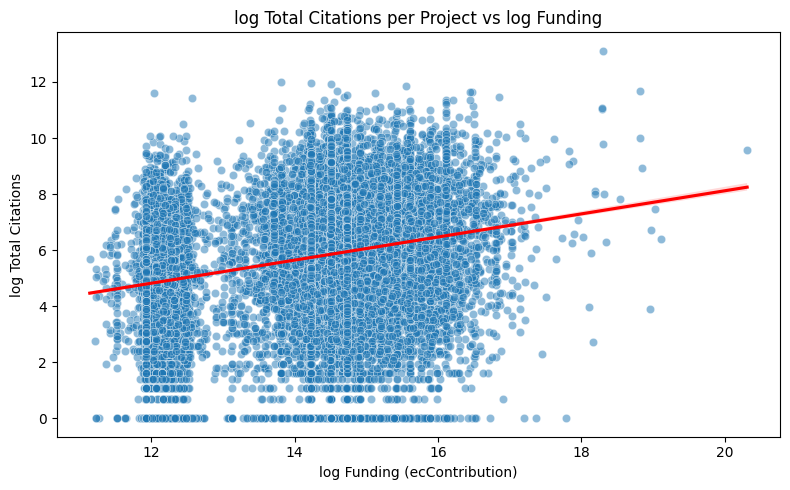

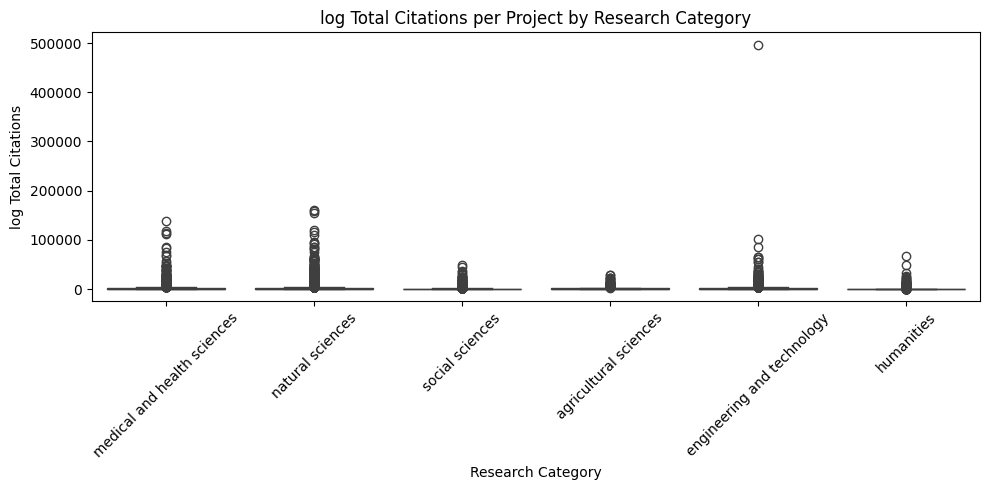

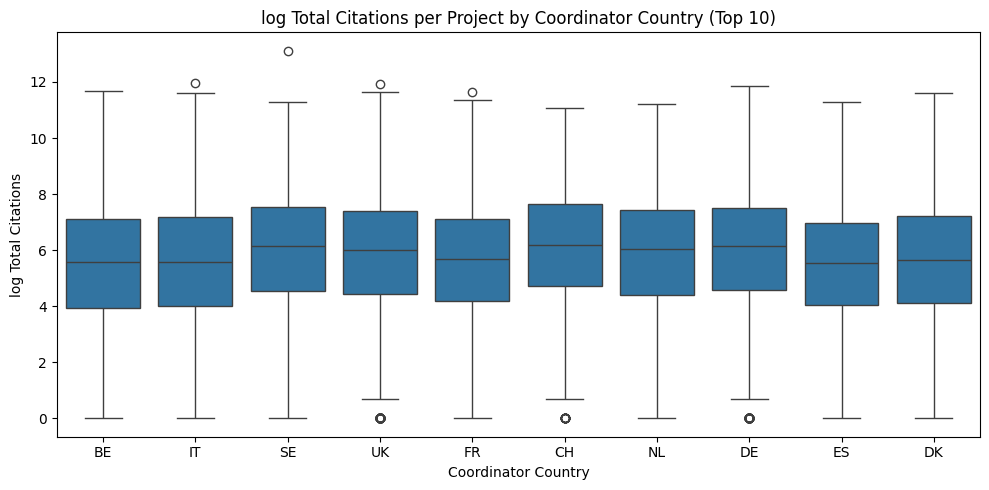

In [18]:

# 3. Prepare features and response
X = df[['log_ecContribution', 'country', 'category', 'years_since_publication']]
y = df['log_total_citations']

# 4. Build regression pipeline with one-hot encoding for categorical variables
categorical_features = ['country', 'category']
numeric_features = ['log_ecContribution', 'years_since_publication']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

reg_pipe = Pipeline([
    ('pre', preprocessor),
    ('reg', LinearRegression())
])

# 5. Fit model
reg_pipe.fit(X, y)

# 6. ANOVA-like summary: show coefficients
feature_names = reg_pipe.named_steps['pre'].get_feature_names_out()
coefs = reg_pipe.named_steps['reg'].coef_
intercept = reg_pipe.named_steps['reg'].intercept_

print("Intercept:", intercept)
print("Coefficients:")
for name, coef in zip(feature_names, coefs):
    print(f"{name}: {coef:.3f}")

# 7. Plot: Citations vs Funding with regression line
plt.figure(figsize=(8, 5))
sns.scatterplot(x='log_ecContribution', y='log_total_citations', data=df, alpha=0.5)
sns.regplot(x='log_ecContribution', y='log_total_citations', data=df, scatter=False, color='red')
plt.title('log Total Citations per Project vs log Funding')
plt.xlabel('log Funding (ecContribution)')
plt.ylabel('log Total Citations')
plt.tight_layout()
plt.show()

# 8. Plot: Citations by Research Category (boxplot)
plt.figure(figsize=(10, 5))
sns.boxplot(x='category', y='total_citations', data=df)
plt.title('log Total Citations per Project by Research Category')
plt.xlabel('Research Category')
plt.ylabel('log Total Citations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 9. Plot: Citations by Coordinator Country (top 10 countries)
top_countries = df['country'].value_counts().nlargest(10).index
plt.figure(figsize=(10, 5))
sns.boxplot(x='country', y='log_total_citations', data=df[df['country'].isin(top_countries)])
plt.title('log Total Citations per Project by Coordinator Country (Top 10)')
plt.xlabel('Coordinator Country')
plt.ylabel('log Total Citations')
plt.tight_layout()
plt.show()

In [ ]:
# Prepare dropdown options
topic_options = sorted(df['category'].dropna().unique())
country_options = sorted(df['country'].dropna().unique())

dropdown_topic = Dropdown(
    options=topic_options,
    value=topic_options[0],
    description='Research Topic:'
)
dropdown_country = Dropdown(
    options=country_options,
    value=country_options[0],
    description='Coordinator Country:'
)
out_funding_citations = Output()

def plot_funding_vs_citations(topic, country):
    data = df[(df['category'] == topic) & (df['country'] == country)]
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='log_ecContribution', y='log_total_citations', data=data, alpha=0.6)
    if not data.empty:
        sns.regplot(x='log_ecContribution', y='log_total_citations', data=data, scatter=False, color='red')
    plt.title(f'log Citations vs log Funding\n{topic} / {country}')
    plt.xlabel('Funding (log_ecContribution)')
    plt.ylabel('log Total Citations')
    plt.tight_layout()
    plt.show()

def update_plot(change=None):
    with out_funding_citations:
        out_funding_citations.clear_output(wait=True)
        plot_funding_vs_citations(dropdown_topic.value, dropdown_country.value)

dropdown_topic.observe(update_plot, names='value')
dropdown_country.observe(update_plot, names='value')

display(VBox([dropdown_topic, dropdown_country, out_funding_citations]))
update_plot()

In [21]:
# 1. Model fit metrics (R^2, RMSE) on training data
y_pred = reg_pipe.predict(X)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"R^2 (training): {r2:.3f}")
print(f"RMSE (training): {rmse:.2f}")

# 2. Statistical significance of coefficients using statsmodels
# Prepare design matrix with one-hot encoding (same as pipeline)
X_enc = reg_pipe.named_steps['pre'].transform(X)
X_enc = np.asarray(X_enc).astype(float)
X_enc = sm.add_constant(X_enc)
model = sm.OLS(y, X_enc)
results = model.fit()

# Print summary table (coefficients, std err, t, p-values)
feature_names_full = ['Intercept'] + list(feature_names)
summary_df = (
    pd.DataFrame({
        'feature': feature_names_full,
        'coef': results.params,
        'std_err': results.bse,
        't': results.tvalues,
        'p_value': results.pvalues
    })
)
print(summary_df)

# Show which coefficients are significant at alpha=0.05
significant = summary_df[summary_df['p_value'] < 0.05]
print("\nSignificant predictors (p < 0.05):")
print(significant[['feature', 'coef', 'p_value']])

# Optionally, display full statsmodels summary
display(results.summary())

R^2 (training): 0.415
RMSE (training): 1.70
                                         feature      coef   std_err  \
const                                  Intercept -4.802177  1.704957   
x1                               cat__country_AM  3.499942  1.962744   
x2                               cat__country_AT  3.016003  1.701258   
x3                               cat__country_BE  2.902505  1.700832   
x4                               cat__country_BG  3.051770  1.735000   
x5                               cat__country_CH  3.549998  1.700864   
x6                               cat__country_CY  2.827684  1.709060   
x7                               cat__country_CZ  3.354821  1.705606   
x8                               cat__country_DE  3.197163  1.700255   
x9                               cat__country_DK  3.260559  1.701054   
x10                              cat__country_EE  3.383240  1.712899   
x11                              cat__country_EL  2.617306  1.701467   
x12                 

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_total_citations   R-squared:                       0.415
Model:                             OLS   Adj. R-squared:                  0.414
Method:                  Least Squares   F-statistic:                     318.6
Date:                 Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                         18:08:33   Log-Likelihood:                -43776.
No. Observations:                22473   AIC:                         8.765e+04
Df Residuals:                    22422   BIC:                         8.806e+04
Df Model:                           50                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8022      1.705     -2.817      0.005      -8.144      -1.460
x1             3.4999      1.963      1.783      0.075      -0.347       7.347
x2             3.0160      1.701      1.773      0.076      -0.319       6.351
x3             2.9025      1.701      1.707      0.088      -0.431       6.236
x4             3.0518      1.735      1.759      0.079      -0.349       6.452
x5             3.5500      1.701      2.087      0.037       0.216       6.884
x6             2.8277      1.709      1.655      0.098      -0.522       6.178
x7             3.3548      1.706      1.967      0.049       0.012       6.698
x8             3.1972      1.700      1.880      0.060      -0.135       6.530
x9             3.2606      1.701      1.917      0.055      -0.074       6.595
x10            3.3832      1.713      1.975      0.048       0.026       6.741
x11            2.6173      1.701      1.538      0.124      -0.718       5.952
x12            2.9798      1.700      1.753      0.080      -0.353       6.313
x13            3.2187      1.702      1.891      0.059      -0.117       6.554
x14            2.8177      2.405      1.172      0.241      -1.896       7.532
x15            2.9176      1.700      1.716      0.086      -0.415       6.250
x16            0.8137      2.404      0.339      0.735      -3.897       5.525
x17            4.4844      2.404      1.866      0.062      -0.227       9.196
x18            3.0326      1.736      1.747      0.081      -0.371       6.436
x19            3.0678      1.712      1.792      0.073      -0.287       6.423
x20            2.8869      1.702      1.696      0.090      -0.449       6.222
x21            2.9452      1.702      1.731      0.084      -0.390       6.281
x22            2.7778      1.728      1.607      0.108      -0.609       6.165
x23            3.0304      1.700      1.782      0.075      -0.302       6.363
x24            2.6500      1.732      1.530      0.126      -0.745       6.046
x25            2.9213      1.714      1.705      0.088      -0.437       6.280
x26            3.4393      1.760      1.955      0.051      -0.010       6.888
x27            3.6285      2.404      1.510      0.131      -1.083       8.340
x28            1.3065      2.405      0.543      0.587      -3.407       6.020
x29            2.9583      1.756      1.685      0.092      -0.483       6.400
x30            0.6009      2.405      0.250      0.803      -4.113       5.314
x31            3.2017      1.700      1.883      0.060      -0.131       6.535
x32            2.9364      1.702      1.725      0.084      -0.399       6.272
x33            2.6908      1.707      1.577      0.115      -0.654       6.036
x34            2.9790      1.702      1.750      0.080      -0.357       6.315
x35            2.3250      1.721      1.351      0.177      -1.049    

Intercept (no country): -1.649819723972275
Coefficients (no country):
cat__category_engineering and technology: -0.203
cat__category_humanities: -1.439
cat__category_medical and health sciences: 0.340
cat__category_natural sciences: 0.218
cat__category_social sciences: -0.599
num__log_ecContribution: 0.392
num__years_since_publication: 0.516
                                         feature      coef   std_err  \
const                                  Intercept -1.649820  0.141575   
x1      cat__category_engineering and technology -0.202790  0.082420   
x2                      cat__category_humanities -1.439129  0.093786   
x3     cat__category_medical and health sciences  0.339868  0.084626   
x4                cat__category_natural sciences  0.217962  0.080209   
x5                 cat__category_social sciences -0.598839  0.085043   
x6                       num__log_ecContribution  0.391917  0.008309   
x7                  num__years_since_publication  0.516059  0.004903   

       

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     log_total_citations   R-squared:                       0.408
Model:                             OLS   Adj. R-squared:                  0.408
Method:                  Least Squares   F-statistic:                     2214.
Date:                 Tue, 27 May 2025   Prob (F-statistic):               0.00
Time:                         18:08:41   Log-Likelihood:                -43912.
No. Observations:                22473   AIC:                         8.784e+04
Df Residuals:                    22465   BIC:                         8.790e+04
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6498      0.142    -11.653      0.000      -1.927      -1.372
x1            -0.2028      0.082     -2.460      0.014      -0.364      -0.041
x2            -1.4391      0.094    -15.345      0.000      -1.623      -1.255
x3             0.3399      0.085      4.016      0.000       0.174       0.506
x4             0.2180      0.080      2.717      0.007       0.061       0.375
x5            -0.5988      0.085     -7.042      0.000      -0.766      -0.432
x6             0.3919      0.008     47.167      0.000       0.376       0.408
x7             0.5161      0.005    105.253      0.000       0.506       0.526
==============================================================================
Omnibus:                     1552.845   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2071.962
Skew:                          -0.618   Prob(JB):                         0.00
Kurtosis:                       3.827   Cond. No.                         260.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

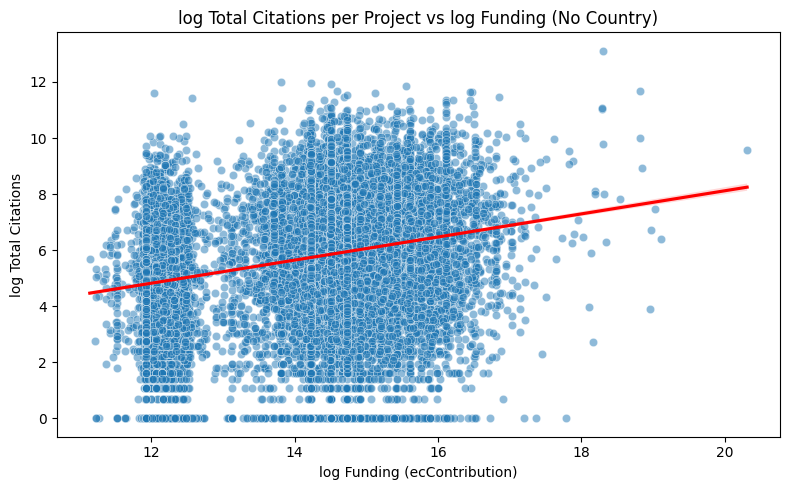

In [22]:
# Prepare features and response (exclude 'country')
X_no_country = df[['log_ecContribution', 'category', 'years_since_publication']]
y = df['log_total_citations']

# Pipeline: one-hot encode 'category', passthrough numerics
preprocessor_no_country = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['category']),
        ('num', 'passthrough', ['log_ecContribution', 'years_since_publication'])
    ]
)

reg_pipe_no_country = Pipeline([
    ('pre', preprocessor_no_country),
    ('reg', LinearRegression())
])

# Fit model
reg_pipe_no_country.fit(X_no_country, y)

# Coefficient names and values
feature_names_nc = reg_pipe_no_country.named_steps['pre'].get_feature_names_out()
coefs_nc = reg_pipe_no_country.named_steps['reg'].coef_
intercept_nc = reg_pipe_no_country.named_steps['reg'].intercept_

print("Intercept (no country):", intercept_nc)
print("Coefficients (no country):")
for name, coef in zip(feature_names_nc, coefs_nc):
    print(f"{name}: {coef:.3f}")

# Statistical significance with statsmodels
X_enc_nc = reg_pipe_no_country.named_steps['pre'].transform(X_no_country)
X_enc_nc = np.asarray(X_enc_nc).astype(float)
X_enc_nc = sm.add_constant(X_enc_nc)
model_nc = sm.OLS(y, X_enc_nc)
results_nc = model_nc.fit()

# Print summary table (coefficients, std err, t, p-values)
feature_names_full_nc = ['Intercept'] + list(feature_names_nc)
summary_df_nc = (
    pd.DataFrame({
        'feature': feature_names_full_nc,
        'coef': results_nc.params,
        'std_err': results_nc.bse,
        't': results_nc.tvalues,
        'p_value': results_nc.pvalues
    })
)
print(summary_df_nc)

# Show significant predictors
significant_nc = summary_df_nc[summary_df_nc['p_value'] < 0.05]
print("\nSignificant predictors (p < 0.05):")
print(significant_nc[['feature', 'coef', 'p_value']])

# Optionally, display full statsmodels summary
display(results_nc.summary())

# Plot: Citations vs Funding with regression line (no country)
plt.figure(figsize=(8, 5))
sns.scatterplot(x='log_ecContribution', y='log_total_citations', data=df, alpha=0.5)
sns.regplot(x='log_ecContribution', y='log_total_citations', data=df, scatter=False, color='red')
plt.title('log Total Citations per Project vs log Funding (No Country)')
plt.xlabel('log Funding (ecContribution)')
plt.ylabel('log Total Citations')
plt.tight_layout()
plt.show()



In [23]:
# Dropdown for research category
category_options = sorted(df['category'].dropna().unique())
dropdown_cat = Dropdown(
    options=category_options,
    value=category_options[0],
    description='Category:'
)
out_plot = Output()

def plot_scatter_regression(selected_cat):
    subset = df[df['category'] == selected_cat]
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='log_ecContribution', y='log_total_citations', data=subset, alpha=0.6)
    if not subset.empty:
        sns.regplot(
            x='log_ecContribution',
            y='log_total_citations',
            data=subset,
            scatter=False,
            color='red',
            label='Regression line'
        )
    plt.title(f'log Total Citations vs log Funding\nCategory: {selected_cat}')
    plt.xlabel('log Funding (ecContribution)')
    plt.ylabel('log Total Citations')
    plt.tight_layout()
    plt.show()

def update_plot(change=None):
    with out_plot:
        out_plot.clear_output(wait=True)
        plot_scatter_regression(dropdown_cat.value)

dropdown_cat.observe(update_plot, names='value')

display(VBox([dropdown_cat, out_plot]))
update_plot()

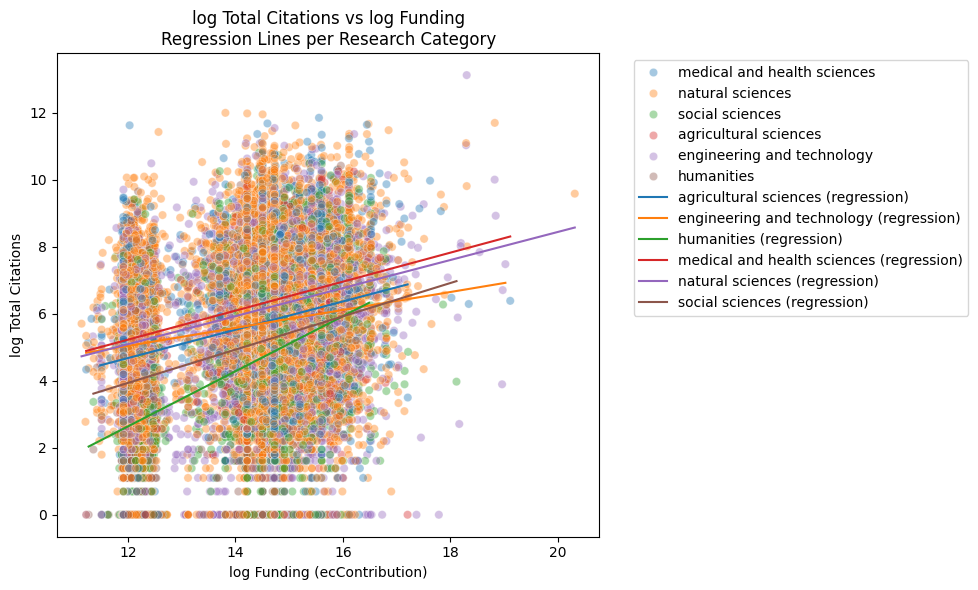

In [24]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab10", n_colors=len(category_options))

# Scatter all points, colored by category
sns.scatterplot(
    x='log_ecContribution',
    y='log_total_citations',
    hue='category',
    data=df,
    alpha=0.4,
    palette=palette,
    legend='full'
)

# Plot regression line for each category
for i, cat in enumerate(category_options):
    subset = df[df['category'] == cat]
    if len(subset) > 1:
        # Fit linear regression for this category
        x = subset['log_ecContribution']
        y = subset['log_total_citations']
        coef = np.polyfit(x, y, 1)
        x_vals = np.linspace(x.min(), x.max(), 100)
        y_vals = coef[0] * x_vals + coef[1]
        plt.plot(x_vals, y_vals, color=palette[i], label=f"{cat} (regression)")

plt.title('log Total Citations vs log Funding\nRegression Lines per Research Category')
plt.xlabel('log Funding (ecContribution)')
plt.ylabel('log Total Citations')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

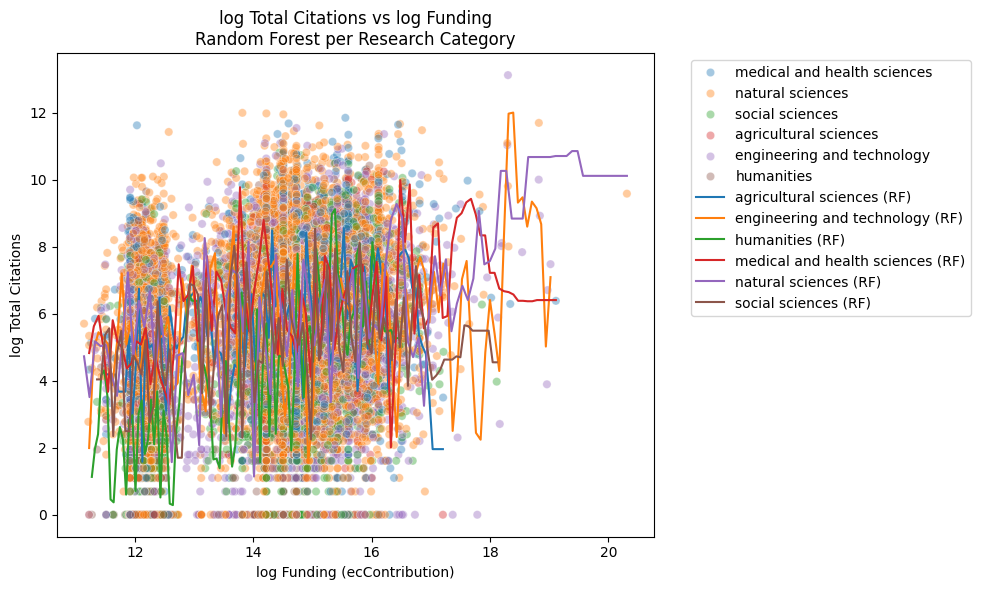

In [25]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab10", n_colors=len(category_options))

sns.scatterplot(
    x='log_ecContribution',
    y='log_total_citations',
    hue='category',
    data=df,
    alpha=0.4,
    palette=palette,
    legend='full'
)

for i, cat in enumerate(category_options):
    subset = df[df['category'] == cat]
    if len(subset) > 10:  # Need enough data for ML
        X = subset[['log_ecContribution']].values
        y = subset['log_total_citations'].values
        # Fit Random Forest
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
        y_pred = model.predict(x_vals)
        plt.plot(x_vals, y_pred, color=palette[i], label=f"{cat} (RF)")

plt.title('log Total Citations vs log Funding\nRandom Forest per Research Category')
plt.xlabel('log Funding (ecContribution)')
plt.ylabel('log Total Citations')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()